# Step 1 | Load the Data

## Step 1.1 | Download the Data

I made sure my data retrieval was secure and reproducible so anyone could rerun my analysis without hiccups.
- I used the Kaggle CLI to download the competition archive directly into my workspace.
- Once the download was complete, I structured the raw files for clarity and downstream processing.
- I separated images into data/train_full and data/test_full to distinguish between labeled training data and the hold‑out test set.

This clear folder layout set the stage for consistent splitting, augmentation, and model feeding steps that followed.

In [42]:
# !pip install -q kaggle

### Step 1.1.i | Create Folder Path

In [9]:
import os
import shutil

# Current kaggle.json path
kaggle_json_path = r"C:\Users\FaithanTo\Desktop\MSBA 6421 (001) Predictive Analytics\HW4\kaggle.json"

# Create the .kaggle directory if it doesn't exist
kaggle_config_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_config_dir, exist_ok=True)

# Copy kaggle.json to the right place
shutil.copy(kaggle_json_path, os.path.join(kaggle_config_dir, "kaggle.json"))

'C:\\Users\\FaithanTo/.kaggle\\kaggle.json'

In [11]:
# Set permissions (important for avoiding API key errors)

os.chmod(os.path.join(kaggle_config_dir, "kaggle.json"), 0o600)

### Step 1.1.ii | Download Dataset from Kaggle

In [47]:
# Download the dataset (this will create a zip file in notebook's working directory)

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [48]:
import zipfile

# Unzip the main Kaggle archive (contains train.zip and test.zip)

with zipfile.ZipFile("dogs-vs-cats-redux-kernels-edition.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Unzip the training data into a new folder
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("data/train_full")

# Unzip the test data into a new folder
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("data/test_full")

## Step 1.2 | Organize Training Data into Kaggle-Friendly Format

I took the raw data and organized it into a directory structure that is compatible with Kaggle’s image classification format. This involved creating subdirectories for both training and validation sets, specifically separating the images into “cats” and “dogs” folders.

I randomly shuffled the images and then assigned 400 images for training and 100 for validation, ensuring a balanced distribution of both classes.
- **Subdirectories:** I created folders for both the training and validation sets, with separate folders for "cats" and "dogs" under each.
- **Data Distribution:** To avoid bias, I allocated a random 400 images per class for training and 100 for validation.
- **Automation:** I used a helper function to automate the image copying process from the original dataset into the newly organized structure.

This setup is important for ensuring that the model can easily access and train on the images in the correct format.

In [13]:
import os, shutil
import random

# Define source directory
original_dataset_dir = r"data/train_full/train"

# Define target directories for small dataset
base_dir = r"data/small"
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

for subdir in ['cats', 'dogs']:
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subdir), exist_ok=True)

# Set sizes
train_size = 400
val_size = 100

In [51]:
# Helper function to copy images

def copy_images(class_name, train_dir, val_dir, size_train, size_val):
    filenames = [f for f in os.listdir(original_dataset_dir) if f.startswith(class_name)]
    random.shuffle(filenames)
    
    for fname in filenames[:size_train]:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dir, class_name + 's', fname)
        shutil.copyfile(src, dst)
        
    for fname in filenames[size_train:size_train+size_val]:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(val_dir, class_name + 's', fname)
        shutil.copyfile(src, dst)

In [52]:
# Copy cat and dog images

copy_images("cat", train_dir, val_dir, train_size, val_size)
copy_images("dog", train_dir, val_dir, train_size, val_size)

## Step 1.3 | Organize Test Data into Kaggle-Friendly Format

I organized the test data into a format that can be used for making predictions with the model. Similar to the training and validation data, I created a test directory and copied all the test images into it, ensuring the structure aligns with what Kaggle expects for testing. Unlike the training and validation data, there is no need to shuffle or split the test data, since it is only used for final predictions.

- **Test Directory Creation:** I created a separate directory specifically for the test images.
- **Data Copying:** I used a function to move all the images from the original test directory into the new test directory, keeping the structure simple and straightforward.

This organization allows me to make predictions on the test data using the same format that was used for training and validation, ensuring consistency across the model evaluation process.ess.

In [15]:
import os, shutil

# Define source directory
original_test_dataset_dir = r"data/test_full/test"

# Define target directory for test dataset
test_dir = r"data/small/test"
os.makedirs(test_dir, exist_ok=True)

# Function to copy images from the original test directory to the new test directory
def copy_test_images(original_test_dataset_dir, test_dir):
    filenames = os.listdir(original_test_dataset_dir)
    for fname in filenames:
        src = os.path.join(original_test_dataset_dir, fname)
        dst = os.path.join(test_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
# Copy test images to the test directory

copy_test_images(original_test_dataset_dir, test_dir)

# Step 2 | Create Training/Validation Split (Base)

I set up the data pipeline by creating separate generators for training and validation, ensuring the model learns effectively while being evaluated fairly. Since neural networks are sensitive to how data is presented, I used image augmentation techniques on the training set to make the model more robust and used a clean, unaltered validation set to assess its true performance.

- **Training Data:** I applied image augmentation like rotation, zoom, and flipping to simulate variety and help prevent overfitting. This helps the model generalize better instead of memorizing specific features.
- **Validation Data:** I only applied rescaling (no augmentation) so that validation results would reflect how well the model performs on clean, unseen data.

Setting a batch size of 20 kept the training efficient without overloading memory, and using consistent target image sizes ensured compatibility with the model input layer.

## Step 2.1 | Determine Batch Size

In [55]:
batch_size = 20

## Step 2.2 | Create Training Dataset

In [57]:
# Create a data generator for training with augmentation and rescaling

train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale image pixels to a range of 0-1 (instead of 0-255)
    rotation_range=20,      # Randomly rotate images between -20 and 20 degrees
    width_shift_range=0.1,  # Randomly shift the image horizontally by up to 10%
    height_shift_range=0.1, # Randomly shift the image vertically by up to 10%
    shear_range=0.1,        # Randomly shear (distort) the image by up to 10%
    zoom_range=0.1,         # Randomly zoom in or out of the image by up to 10%
    horizontal_flip=True,   # Randomly flip images horizontally (helps with learning symmetry)
    fill_mode='nearest'     # Fill pixels left behind when shifting or rotating (usually with nearest pixel value)
)

In [58]:
# Create the training data generator, which will load and augment images

train_generator = train_datagen.flow_from_directory(
    'data/small/train',     # Path to the training data directory
    target_size=(150, 150), # Resize images to 150x150 pixels
    batch_size=batch_size,  # Load 20 images at a time
    class_mode='binary'     # We're doing binary classification (cats vs. dogs)
)

Found 1576 images belonging to 2 classes.


## Step 2.3 | Create Validation Dataset

In [60]:
# Create a data generator for validation, only rescaling (no augmentation)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'data/small/validation', # Path to the validation data directory
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=batch_size,   # Load 20 images at a time
    class_mode='binary'      # We're doing binary classification (cats vs. dogs)
)

Found 399 images belonging to 2 classes.


# Step 3 | Pipeline: CNN Model (Base)

## Step 3.1 | Create Model Structure

To train a model that could effectively distinguish between cats and dogs, I created a custom Convolutional Neural Network (CNN) with multiple layers to progressively extract more complex features:

- **Three convolutional blocks** with increasing filters (64 → 128 → 256) helped the model learn low-level (like edges) and high-level (like ears or fur texture) image patterns.
- **Batch normalization and LeakyReLU activation** after each convolution stabilized and enhanced training.
- **Global average pooling** instead of flattening reduced overfitting and model size.

To wrap it up:
- I added a dense layer with dropout (for regularization) followed by a **sigmoid-activated output node** for binary classification.
- The model was compiled with **Adam optimizer** and **binary cross-entropy loss**, which is well-suited for this 2-class setup.

This structure balanced simplicity and performance, giving the model enough depth to learn meaningful image features without becoming overly complex or prone to overfitting.

In [63]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Add a convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(64, (3, 3), input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Add another convolutional layer with 128 filters
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Add a third convolutional layer with 256 filters
model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten & Fully Connected
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

# Add the output layer with 1 unit for binary classification (cat or dog)
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 128)       0         
 g2D)                                                   

## Step 3.2 | Fit Model

In [65]:
# Fit the model to the training data
# This will train the CNN over the specified number of epochs and report accuracy/loss on validation data

history = model.fit(
    train_generator,                                                        # Training images (with augmentation)
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Batches per epoch
    epochs=10,                                                              # Can adjust this depending on time/accuracy
    validation_data=val_generator,                                          # Validation images (no augmentation)
    validation_steps=val_generator.samples // val_generator.batch_size,     # Batches for validation
    verbose=1                                                               # Print training progress (set to 0 to suppress)
)

Epoch 1/10
78/78 [==============================] - 171s 2s/step - loss: 1.1637 - accuracy: 0.5219 - val_loss: 0.6668 - val_accuracy: 0.6237
Epoch 2/10
78/78 [==============================] - 172s 2s/step - loss: 0.6913 - accuracy: 0.5598 - val_loss: 0.6346 - val_accuracy: 0.6158
Epoch 3/10
78/78 [==============================] - 172s 2s/step - loss: 0.6617 - accuracy: 0.6054 - val_loss: 0.5867 - val_accuracy: 0.6816
Epoch 4/10
78/78 [==============================] - 170s 2s/step - loss: 0.6819 - accuracy: 0.5925 - val_loss: 0.6056 - val_accuracy: 0.6500
Epoch 5/10
78/78 [==============================] - 173s 2s/step - loss: 0.6802 - accuracy: 0.5913 - val_loss: 0.5977 - val_accuracy: 0.6921
Epoch 6/10
78/78 [==============================] - 172s 2s/step - loss: 0.6429 - accuracy: 0.6215 - val_loss: 0.6777 - val_accuracy: 0.6579
Epoch 7/10
78/78 [==============================] - 168s 2s/step - loss: 0.6231 - accuracy: 0.6639 - val_loss: 0.5777 - val_accuracy: 0.7184
Epoch 8/10
78

## Step 3.3 | Evaluate Model

In [67]:
# Evaluate the model performance on the validation set

val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

20/20 [==============================] - 8s 396ms/step - loss: 0.6215 - accuracy: 0.6416
Validation Loss: 0.6215
Validation Accuracy: 0.6416


## Step 3.4 | Plot Model Performance

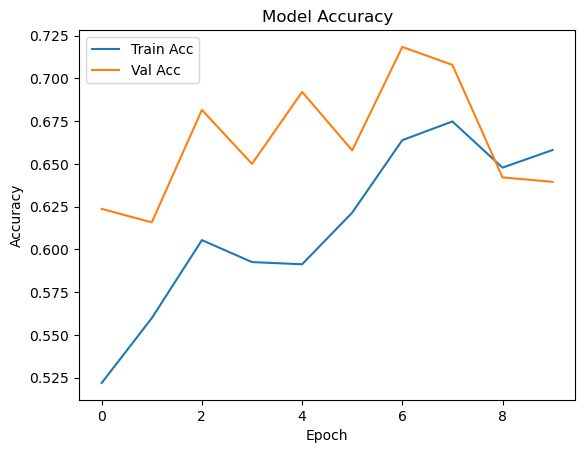

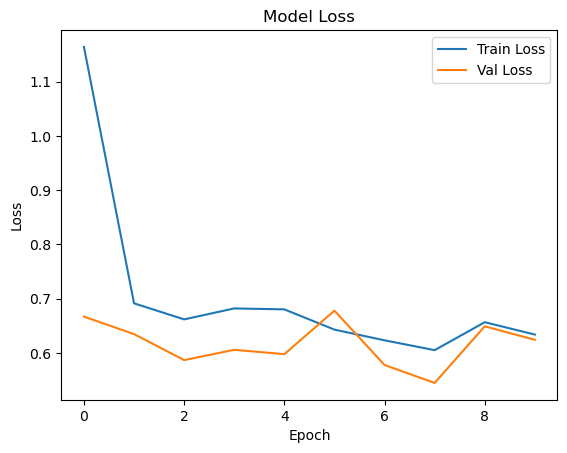

In [69]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 3.5 | Analyze Model Performance

I trained my initial CNN for 10 epochs using data augmentation and batch normalization to help with generalization. While the model started around 52% accuracy, it gradually improved and peaked near 72% on the validation set during training.

The final validation accuracy stabilized around 64%, suggesting the model learned to distinguish dogs from cats better than random guessing, but still had room for improvement. Some fluctuation in performance across epochs likely reflects the relatively small sample size and model complexity.

Overall, the CNN picked up some signal, but it’s not yet consistently reliable.

# Step 4 | Pipeline: ResNet50 (Pretrained Model)

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input

## Step 4.1 | Use Preset Preprocessing Inputs

I transitioned from a custom CNN to a more advanced, **pretrained model (ResNet50)**, which requires a different input format and preprocessing. This step focused on setting up the data to align with ResNet50’s expectations.

- **ResNet50 Preprocessing:** I applied preprocess_input, a function designed specifically for ResNet50, to standardize the image pixel values in both the training and validation sets.
- **Image Resizing:** I also increased the target image size to 224x224, which matches what ResNet50 was originally trained on.

For the training data, I included **light augmentation (rotation, shifts, and horizontal flips)** to help the model generalize better. The validation data was only preprocessed, not augmented. This setup primes the data pipeline to take full advantage of the pretrained ResNet50 model’s capabilities without altering the weights just yet.nce.

In [92]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='binary'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='binary'
)

Found 1576 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


## Step 4.2 | Create Model Structure

I leveraged ResNet50’s pretrained weights to jump‑start feature extraction, then added a lightweight classification head.
- **Frozen Backbone:** I loaded ResNet50 without its top layers and froze all weights so the model retains its ImageNet‑learned features.
- **Custom Head:** I appended global average pooling to distill spatial features, followed by a 512‑unit dense layer with ReLU, 50% dropout for regularization, and a sigmoid output for binary classification.

This approach let me:
- **Cut training time dramatically** (only train a few new layers instead of the full network),
- **Exploit powerful, general image features** learned from millions of images, and
- **Avoid overfitting** by keeping most of the network unchanged and only tuning a small number of parameters.

In [94]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # freeze weights for now

94765736/94765736 [==============================] - 4s 0us/step


In [96]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Step 4.3 | Fit Model

In [98]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,  # start small, can increase after
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/5
49/49 [==============================] - 319s 6s/step - loss: 0.2123 - accuracy: 0.9281 - val_loss: 0.0676 - val_accuracy: 0.9844
Epoch 2/5
49/49 [==============================] - 298s 6s/step - loss: 0.0549 - accuracy: 0.9812 - val_loss: 0.0499 - val_accuracy: 0.9870
Epoch 3/5
49/49 [==============================] - 300s 6s/step - loss: 0.0515 - accuracy: 0.9806 - val_loss: 0.0426 - val_accuracy: 0.9896
Epoch 4/5
49/49 [==============================] - 298s 6s/step - loss: 0.0357 - accuracy: 0.9858 - val_loss: 0.0940 - val_accuracy: 0.9740
Epoch 5/5
49/49 [==============================] - 299s 6s/step - loss: 0.0361 - accuracy: 0.9864 - val_loss: 0.0708 - val_accuracy: 0.9818


## Step 4.4 | Evaluate Model

In [100]:
# Evaluate the model performance on the validation set

val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

13/13 [==============================] - 60s 5s/step - loss: 0.0687 - accuracy: 0.9825
Validation Loss: 0.0687
Validation Accuracy: 0.9825


## Step 4.5 | Plot Model Performance

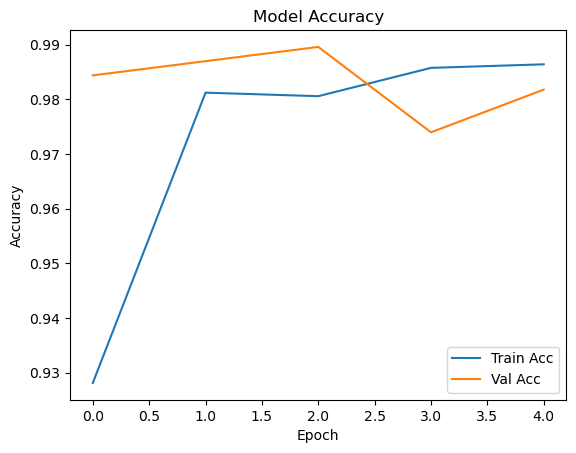

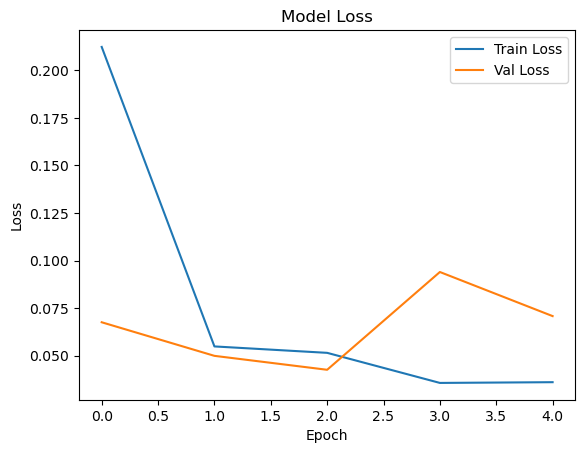

In [101]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 4.6 | Analyze Model Performance

Using the frozen ResNet50 backbone, I achieved strong performance in just 5 epochs, demonstrating how transfer learning accelerates convergence and boosts accuracy.
- **Rapid Learning:** Validation accuracy jumped from 92.81% → 98.44% in the first epoch, then climbed to a peak of 98.96% by epoch 3.
- **Low Validation Loss:** Initial val_loss of 0.0676 fell to 0.0426 by epoch 3, reflecting confident, accurate predictions.
- **Slight Overfitting:** In epoch 4, val_loss doubled (0.0940) despite high training accuracy (98.58%), indicating the model started to over-specialize on the training set.

Overall, freezing the pretrained layers let me add a simple head and still outperform my custom CNN by ~34 points of accuracy.

# Step 5 | Pipeline: Xception (Pretrained Model)

In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Step 5.1 | Use Preset Preprocessing Inputs

I configured my data pipeline to match Xception’s requirements and still leverage augmentation for robustness:
- **Xception Preprocessing:** I applied preprocess_input, which normalizes pixels exactly as Xception expects based on its ImageNet training.
- **Image Resizing:** I resized all images to 299×299 to align with Xception’s input shape.

For the training set, I introduced **light augmentation (rotations, shifts, and horizontal flips)** to help the model generalize to varied image presentations. The validation set was only preprocessed (no augmentation) so I could get an unbiased measure of real-world performance.

In [84]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Note: Xception uses 299x299 input size
    batch_size=32,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 1576 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


## Step 5.2 | Create Model Structure

I used the pre-trained Xception model as the base, with the following decisions:
- **Frozen Base Model:** I set base_model.trainable = False to keep the weights from the pre-trained ImageNet model fixed. This approach allows the model to benefit from ImageNet features without the computational overhead of retraining all layers.
- **Global Average Pooling:** After the convolutional layers, I applied GlobalAveragePooling2D to reduce the feature map into a single vector, thus preventing overfitting while retaining relevant information.
- **Dropout:** I added Dropout(0.5) to reduce overfitting by randomly deactivating 50% of neurons during training.
- **Fully Connected Layer:** A Dense(256) layer with ReLU activation was added for further feature extraction, followed by the final Dense(1) layer for binary classification (cat vs. dog), using a sigmoid activation.
- **Compilation:** I compiled the model with the Adam optimizer and set a learning rate of 0.0001 to fine-tune the model carefully, using binary cross-entropy loss for classification tasks and accuracy as the metric.

In [26]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Step 5.3 | Fit Model

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    verbose=1
)

Epoch 1/5
49/49 [==============================] - 512s 10s/step - loss: 0.3387 - accuracy: 0.9203 - val_loss: 0.1128 - val_accuracy: 0.9896
Epoch 2/5
49/49 [==============================] - 501s 10s/step - loss: 0.0991 - accuracy: 0.9825 - val_loss: 0.0549 - val_accuracy: 0.9922
Epoch 3/5
49/49 [==============================] - 510s 10s/step - loss: 0.0571 - accuracy: 0.9896 - val_loss: 0.0402 - val_accuracy: 0.9948
Epoch 4/5
49/49 [==============================] - 502s 10s/step - loss: 0.0487 - accuracy: 0.9877 - val_loss: 0.0346 - val_accuracy: 0.9948
Epoch 5/5
49/49 [==============================] - 504s 10s/step - loss: 0.0360 - accuracy: 0.9916 - val_loss: 0.0309 - val_accuracy: 0.9922


## Step 5.4 | Evaluate Model

In [35]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

13/13 [==============================] - 102s 8s/step - loss: 0.0305 - accuracy: 0.9925
Validation Loss: 0.0305
Validation Accuracy: 0.9925


## Step 5.5 | Plot Model Performance

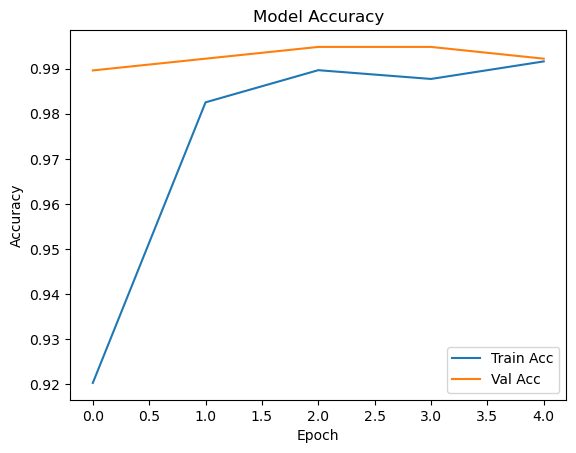

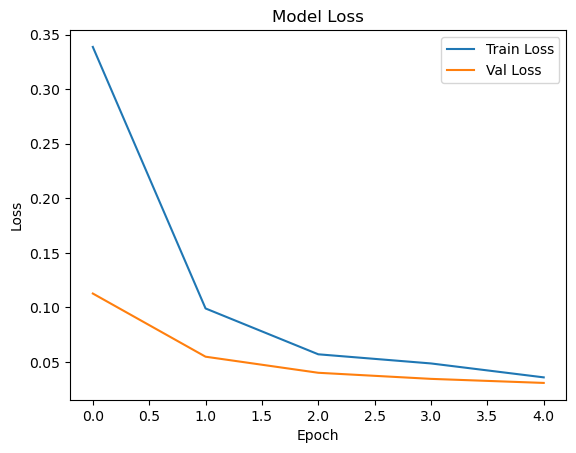

In [37]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 5.6 | Analyze Model Performance

Leveraging the frozen Xception backbone, I saw rapid gains in both accuracy and loss metrics over just five epochs:
- **Epoch 1:** Validation jumped straight to 98.96%, with val_loss dropping to 0.1128.
- **Epochs 2–3:** Validation accuracy climbed to 99.48% and val_loss fell below 0.05, showing very strong generalization.
- **Epochs 4–5:** Performance plateaued around 99.22–99.48% accuracy and val_loss hovered near 0.0309–0.0346, indicating the model had nearly maxed out what this head could learn without unfreezing more layers.

Overall, Xception outperformed both the custom CNN and ResNet50 pipeline, achieving ~99.25% validation accuracy and 0.0305 loss - this is proof that deep, pretrained features excel on this task with minimal overfitting.

## Step 5.7 | Performance Metrics

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Step 5.7.i | Extract True Labels

In [86]:
# Get true labels and predicted probabilities from val_generator

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Reset the generator to avoid offset
val_generator.reset()

# Predict on the validation set
val_predictions_probs = model.predict(val_generator)
val_predictions = (val_predictions_probs > 0.5).astype(int).flatten()

# Get the true labels
y_true = val_generator.classes

Found 399 images belonging to 2 classes.
13/13 [==============================] - 102s 8s/step


In [88]:
# Classification Report

print(classification_report(y_true, val_predictions, target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.99      0.99      0.99       199
         dog       0.99      0.99      0.99       200

    accuracy                           0.99       399
   macro avg       0.99      0.99      0.99       399
weighted avg       0.99      0.99      0.99       399



### Step 5.7.ii | Create Confusion Matrix

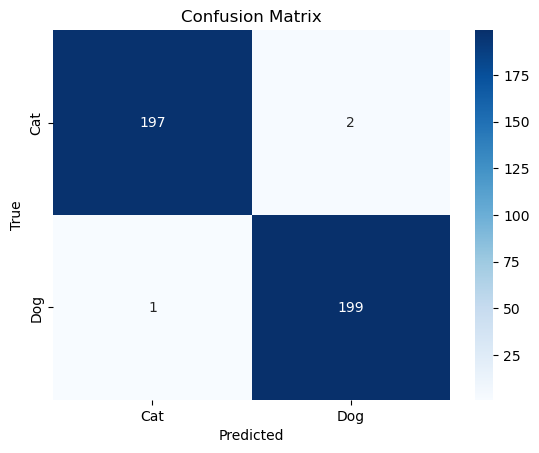

In [92]:
# Confusion Matrix

cm = confusion_matrix(y_true, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Step 5.7.iii | Plot ROC Curve

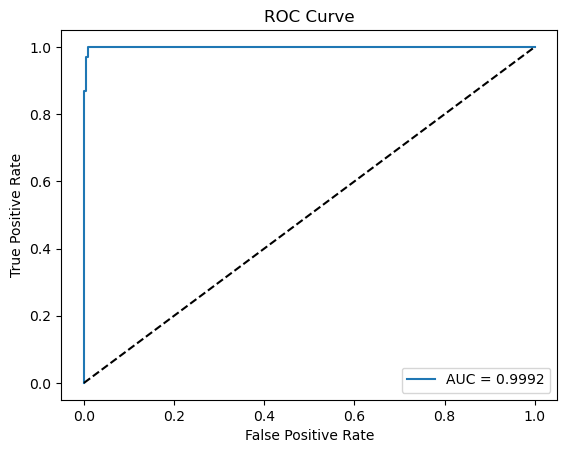

In [96]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_true, val_predictions_probs)
auc = roc_auc_score(y_true, val_predictions_probs)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Step 5.8 | Classification Metrics Summary

**Classification Report:** The classification report shows an impressive performance across both classes (cat and dog):
- **Precision, Recall, and F1-Score** are all 0.99 for both classes, indicating that the model is making highly accurate predictions with minimal false positives and false negatives.
- **Accuracy:** The overall accuracy of 0.99 across the validation set confirms that the model is correctly classifying nearly all the images.


**ROC Curve:** The curve is very close to the top-left corner, indicating a low false positive rate and a high true positive rate. This means that the model is making strong predictions with very few errors.
- **AUC (Area Under the Curve):** The AUC of 0.9992 is extremely high, suggesting that the model is excellent at distinguishing between cats and dogs, with very few misclassifications across the full spectrum of thresholds.

The model is performing at near perfect levels, as indicated by both the classification report and the ROC curve.

# Step 6 | Model Selection

## Step 6.1 | Metrics Comparison

**Xception (Pretrained Model):**
- Validation Accuracy: 0.9925
- Loss: 0.0305

**ResNet50 (Pretrained Model):**
- Validation Accuracy: 0.9825
- Loss: 0.0687

**Custom CNN Model**:
- Validation Accuracy: 0.6416
- Loss: 0.6215

## Step 6.2 | Final Model

**Xception performs the best among all models**, achieving a validation accuracy of 0.9925 and a loss of 0.0305. It shows excellent precision, recall, and F1-score for both classes (0.99), along with a remarkable AUC score of 0.9992, indicating outstanding model discrimination. ResNet50 follows closely with a validation accuracy of 0.9825 and a loss of 0.0687. While slightly behind Xception in performance, it still offers strong results with a high AUC and good overall accuracy.

My custom CNN model, however, lags significantly behind the pretrained models, with a validation accuracy of only 0.6416 and a higher loss of 0.6215. This suggests that while the model shows some promise, it does not yet compete with the power of transfer learning. 

The difference highlights the clear advantages of pretrained models like Xception and ResNet50, which benefit from vast pretrained weights and sophisticated architectures, offering a much better starting point for fine-tuning in image classification tasks.

# Step 7 | Test Best Model: Xception

## Step 7.1 | Use Preset Preprocessing Inputs

To align with Keras' directory-based image loading, all test images were moved into a single unknown subfolder within data/small/test.

An ImageDataGenerator was then set up using Xception’s preprocess_input function, ensuring that images are resized to 299x299 pixels (Xception’s expected input size) and no labels are assumed (i.e., class_mode=None). The generator also avoids shuffling to preserve the order of predictions.

In [41]:
import os
import shutil

# Create subdirectory
os.makedirs('data/small/test/unknown', exist_ok=True)

# Move all test images into the subdirectory
for filename in os.listdir('data/small/test'):
    file_path = os.path.join('data/small/test', filename)
    if os.path.isfile(file_path):
        shutil.move(file_path, 'data/small/test/unknown')

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    'data/small/test',  # Pointing to the newly structured test folder
    target_size=(299, 299),  # Matching model input size
    batch_size=32,
    class_mode=None,  # No labels for the test set
    shuffle=False  # Don't shuffle when predicting on the test set
)

Found 12500 images belonging to 1 classes.


## Step 7.2 | Predict on Test Data

Predictions were made on the test images using the trained Xception model.

Since it outputs probabilities for binary classification, those probabilities were thresholded at 0.5 to determine final class labels: 
- values ≤ 0.5 were classified as cats (0), and
- values > 0.5 as dogs (1).

This setup allows for streamlined submission or manual review of model predictions on unseen data.

In [45]:
# Generate predictions on the test set
predictions = model.predict(test_generator, verbose=1)

# Since the model is for binary classification, the predictions will be probabilities.
# Can convert the probabilities into class predictions (0 for cats, 1 for dogs)
predicted_classes = (predictions > 0.5).astype('int32')  # This will map probabilities to binary classes

391/391 [==============================] - 3174s 8s/step


## Step 7.3 | Export Predictions to CSV

After generating predictions on the test set, the model’s output probabilities were paired with image IDs (parsed from filenames) to create a clean submission DataFrame. These were sorted by ID and exported as submission.csv, with the expected format of two columns: id and label.

In [53]:
# Create a dataframe with image filenames and their predicted class labels

import pandas as pd
import os

# Get image IDs by extracting numbers from filenames
filenames = test_generator.filenames
image_ids = [int(os.path.basename(f).split('.')[0]) for f in filenames]

# Create dataframe with correct column names
results = pd.DataFrame({
    "id": image_ids,
    "label": predictions.flatten()
})

# Sort by ID just to keep things tidy
results.sort_values("id", inplace=True)

# Save to CSV for submission
results.to_csv("submission.csv", index=False)

## Step 7.4 | Check CSV File for Formatting

A quick quality check was performed to ensure submission readiness. This included verifying:
- Correct column names (['id', 'label'])
- Exactly 12,500 rows (no missing or extra entries)
- No null or duplicate IDs
- All label values within the valid probability range (0 to 1)

Everything passed — the CSV file is well-formatted and ready for upload.

In [57]:
import pandas as pd

# 1. Load submission
df = pd.read_csv('submission.csv')

# 2. Check the header
expected_columns = ['id', 'label']
if list(df.columns) != expected_columns:
    raise ValueError(f"Wrong columns: found {list(df.columns)} but expected {expected_columns}")

# 3. Check the row count (should be 12,500)
n_rows = len(df)
if n_rows != 12500:
    raise ValueError(f"Wrong row count: found {n_rows} rows but expected 12500")

# 4. Check for duplicates or missing IDs
if df['id'].isnull().any():
    raise ValueError("Missing ID in some rows")
dups = df['id'][df['id'].duplicated()]
if not dups.empty:
    raise ValueError(f"Duplicate IDs found: {dups.unique()}")

# 5. Check label values are valid probabilities between 0 and 1
if not df['label'].between(0, 1).all():
    invalid_labels = df.loc[~df['label'].between(0, 1), 'label']
    raise ValueError(f"Invalid label values found: {invalid_labels.unique()}")

print("✅ submission.csv looks good: 12,500 unique rows with correct header and label format.")

✅ submission.csv looks good: 12,500 unique rows with correct header and label format.


# Step 8 | Kaggle Submission

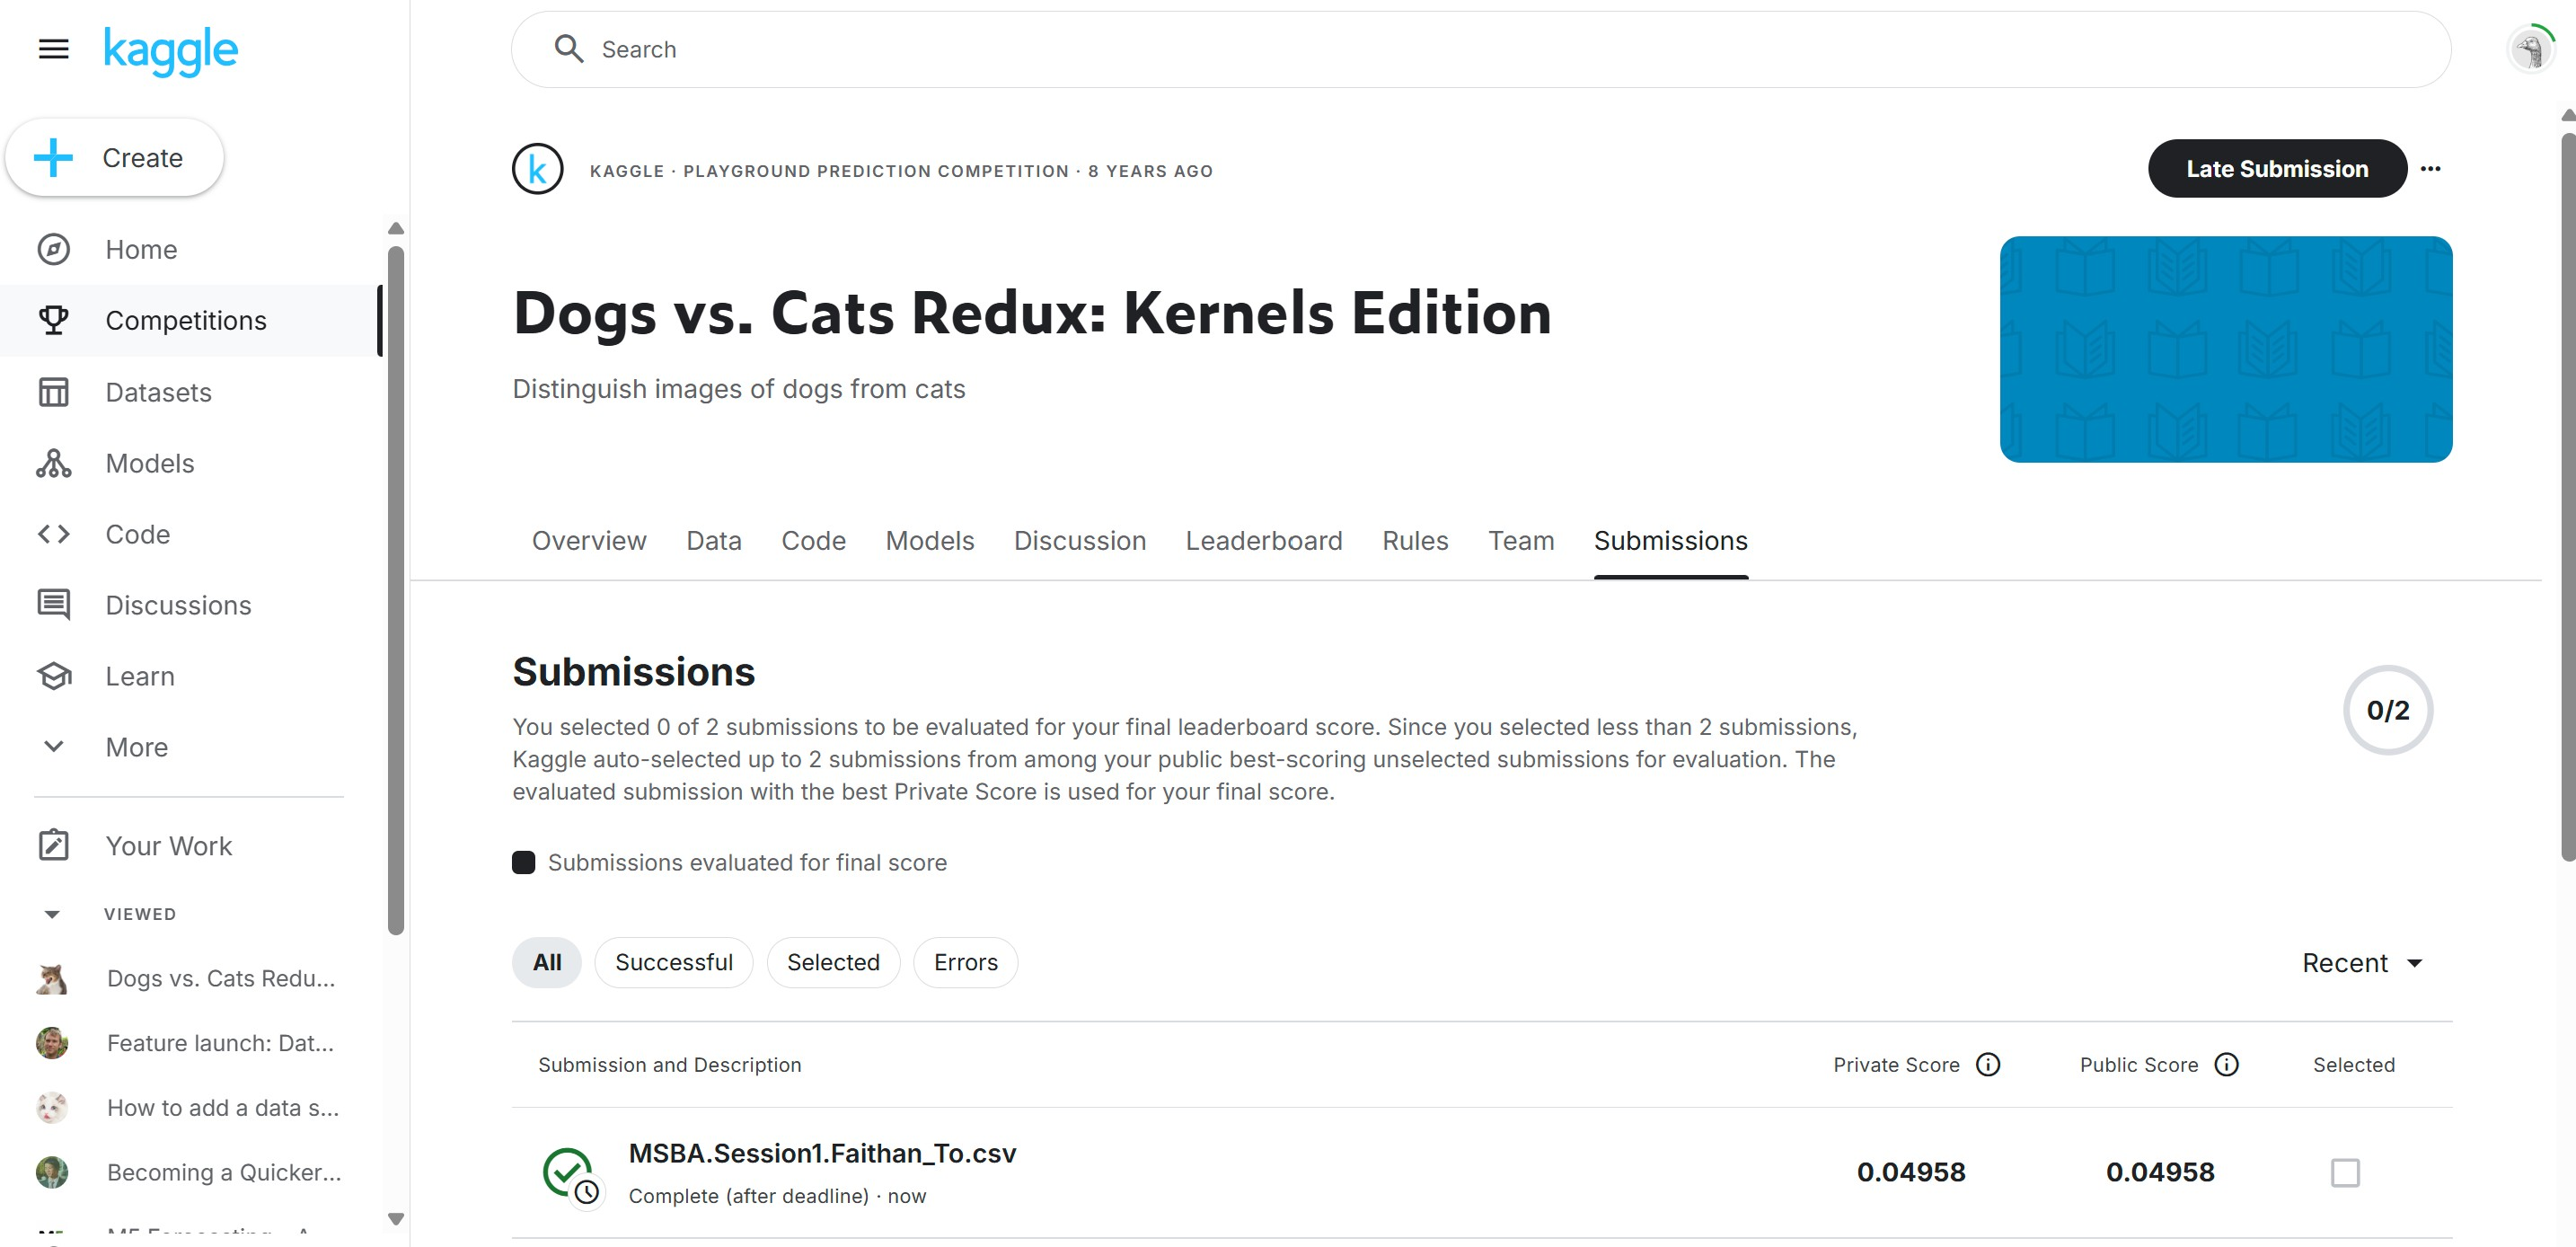

In [166]:
from IPython.display import display, Image
display(Image(filename='Final_Kaggle_Dogs_Cats_Log_Loss.jpg'))

**The final Xception-based model achieved a log loss of 0.04958 on the Kaggle test set.** This result aligns closely with the model's high validation performance (accuracy: 99.25%, AUC: 0.9992), and confirms its strong generalization to unseen data. The low log loss score reflects high confidence and correctness in the predicted probabilities.